In [1]:
#pip install pandas numpy statsmodels seaborn numpy matplotlib

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# this so called "line magic" command, amongst other things, stores the plots in the notebook document.
%matplotlib inline

# library for linear regression
import statsmodels.api as sm

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# warnings supression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# read in forecast dataset and mark all questionmarks as NaNs.
df = pd.read_csv("data/forecast_zalando.csv",
                  na_values='?')
df.head()

# let's drop 2025 since I want this to be forecasted using this new model
# keeping 2024 using the Q1 2024 results of 1.5% increase
df = df.drop(columns=["2025"])
df

,Unnamed: 0,2018,2019,2020,2021,2022,2023,2024
0,GMV,6.6,8.2,10.7,14.3,14.8,14.6,14.8
1,Net Revenue,5.3,6.4,8.0,10.4,10.3,10.1,10.3


In [4]:
# Set 'Unnamed: 0' as index 
df.set_index('Unnamed: 0', inplace=True)

# transpose (flip the axis so years are rows, and GMV/Revenue are columns)
df = df.T.copy()

In [5]:
# should see dataframe now flipped correctly
df

Unnamed: 0,GMV,Net Revenue
2018,6.6,5.3
2019,8.2,6.4
2020,10.7,8.0
2021,14.3,10.4
2022,14.8,10.3
2023,14.6,10.1
2024,14.8,10.3


## Setup the Model

In [6]:
# Assign independent & dependent variables
X = df['Net Revenue'].astype(float) #independent
y = df['GMV'].astype(float)         #dependent

In [7]:
# Add a constant to the independent variable set (intercept term) for 1's
# This is because the statsmodel OLS needs an adjustable intercept
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

In [8]:
# display the regression results
model.summary()

c:\Users\Arny\miniconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GMV   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     823.0
Date:                Thu, 23 May 2024   Prob (F-statistic):           9.64e-07
Time:                        02:15:03   Log-Likelihood:               -0.25593
No. Observations:                   7   AIC:                             4.512
Df Residuals:                       5   BIC:                             4.404
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.1599      0.506     -4.267      0.008      -3.461      -0.859
Net Revenue     1.6303      0.057     28.688      0.000       1.484       1.776
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.402
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.849
Skew:                          -0.820   Prob(JB):                        0.654
Kurtosis:                       2.533   Cond. No.                         40.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Fit
The extremely high t-statistic (28.688) for Net Revenue and its extremely low p-value (0.000) indicate that Net Revenue is a very strong predictor of GMV.

### Very strong relationship Net Revenue and GMV

#### P-Value of 9.64e-07:
Extremely small and much lower than the common significance level of 0.05
#### Statistical Significance:
This very low p-value indicates that it is highly unlikely that the observed relationship between the independent and dependent variables is due to random chance.
#### High confidence: Rejecting the Null Hypothesis:
Since the p-value is so small, we can reject the null hypothesis with high confidence. This suggests that the independent variable (Net Revenue) has a significant effect on the dependent variable (GMV).

In [9]:
# print out the intercept and slope of the model by adressing the parameters via ".params"
intercept, slope = model.params

print(f'intercept: {intercept}, slope: {slope}')

intercept: -2.1599497802887537, slope: 1.630257376020087


####  R-squared $\textbf{R}^2$
Proportion of the variation in $y$ that is explained by the model. Measured on a scale from 0 (bad) to 1 (good)  
As a rule of thumb, the standards for R-Squared are the following:

- a R-Squared above 0.7 is generally be seen as showing a high level of correlation,
- a measure below 0.4 would show a low correlation. 

#### const coef
- This is the intercept, in other words: value of y when x = 0  
#### Net Revenue coef
- This is the slope, in other words: when the Net Revenues increases by 1$, GMV increases by around 1.63

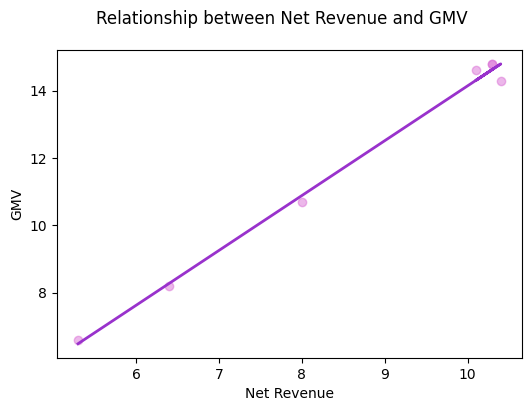

In [10]:
# Plotting the results of the model
fig, ax = plt.subplots(figsize=(6, 4))

x = df['Net Revenue']
y = df['GMV']

# add data points
ax.scatter(x, y, alpha=0.5, color='orchid')
fig.suptitle('Relationship between Net Revenue and GMV')

# plotting the regression line with the help of our calculated intercept and slope variables
ax.plot(x, x*slope+intercept, '-', color='darkorchid', linewidth=2);
ax.set_ylabel("GMV");
ax.set_xlabel("Net Revenue");

## Predict future GMV using the new model

GMV=β0 + β1 *Net Revenue

In [11]:
# coefficients from regression model 
intercept = -2.1599
slope = 1.6303

# Projected Net Revenue for the next 2 years as a dictionary
projected_net_revenue = {
    2025: 10.5,
    2026: 10.7
}

In [12]:
# Function to predict GMV based on the regression equation
def predict_gmv(net_revenue, intercept, slope):
    return intercept + slope * net_revenue

# use a dictionary comprehension to predict GMV for each projected Net Revenue value and store the results.
predictions = {year: predict_gmv(net_revenue, intercept, slope) 
               for year, net_revenue 
               in projected_net_revenue.items()}

In [13]:
# Print the predictions
for year, gmv in predictions.items():
    print(f"Predicted GMV for {year}: {gmv:.2f}")

Predicted GMV for 2025: 14.96
Predicted GMV for 2026: 15.28


In [14]:
# Display a DataFrame for predictions
predictions_df = pd.DataFrame(list(predictions.items()), columns=['Year', 'Predicted GMV'])
predictions_df

,Year,Predicted GMV
0,2025,14.95825
1,2026,15.28431


## Forecast Net Revenue

In [15]:
# create new DataFrame
df_rev_f = df.copy()
# convert index to strings so we can actually remove some year rows
df_rev_f.index.astype(str)
# concentrating on 2021 onwards for data forecasting accuracy
df_rev_f.drop(index=["2018", "2019", "2020"], inplace=True)
df_rev_f

Unnamed: 0,GMV,Net Revenue
2021,14.3,10.4
2022,14.8,10.3
2023,14.6,10.1
2024,14.8,10.3


### Try holt-winters exponential smoothing forecasting

In [16]:
f_model = ExponentialSmoothing(df_rev_f['Net Revenue'], trend='add', seasonal=None, seasonal_periods=1)
fit = f_model.fit()

c:\Users\Arny\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


In [17]:
# Forecast Net Revenue for 2025 and 2026
forecast_net_revenue = fit.forecast(steps=2)
print("Forecasted Net Revenue:")
print(forecast_net_revenue)

Forecasted Net Revenue:
2025-01-01    10.150142
2026-01-01    10.100198
Freq: YS-JAN, dtype: float64


In [18]:
# Prepare a DataFrame to hold both the forecasted Net Revenue and predicted GMV
years = [2025, 2026]
predicted_net_revenue = forecast_net_revenue.values

# coefficients from regression model (already declared earlier, but using again for reference)
intercept = -2.1599
slope = 1.6303

# Predict GMV for the forecasted Net Revenue using earlier function
predicted_gmv = [predict_gmv(net_revenue, intercept, slope) for net_revenue in predicted_net_revenue]

In [19]:
# Create a DataFrame for the predictions
rev_predictions_df = pd.DataFrame({
    'Year': years,
    'Predicted Net Revenue': predicted_net_revenue,
    'Predicted GMV': predicted_gmv
})
rev_predictions_df

,Year,Predicted Net Revenue,Predicted GMV
0,2025,10.150142,14.387877
1,2026,10.100198,14.306452


### Do not like this accuracy as it trends negatively despite it increasing last year and remaining stable

### Use an average growth rate based off the last 3 years then apply GMV regression model

In [20]:
# Calculate the average growth rate based on the last 3 years
recent_years = df_rev_f.index[-3:]
recent_revenue = df_rev_f['Net Revenue'][-3:]

### calculate year over year growth rate

In [21]:
# calculate the percentage change between the current and a prior element
# (current_value - previous_value) / previous_value.
growth_rates = recent_revenue.pct_change().dropna()

# Calculate the average growth rate
average_growth_rate = growth_rates.mean()

In [22]:
# Forecast Net Revenue for the next 2 years based on the average growth rate
last_known_revenue = df_rev_f['Net Revenue'].iloc[-1]
forecast_net_revenue = []

# take last known Net Revenue (2024) and the average growth rate, we forecast Net Revenue for 2025 and 2026.
for year in range(2025, 2027):
    next_revenue = last_known_revenue * (1 + average_growth_rate)
    forecast_net_revenue.append(next_revenue)
    last_known_revenue = next_revenue
    
forecast_net_revenue = pd.Series(forecast_net_revenue, index=[2025, 2026])

# Round forecasted Net Revenue to 6 decimal places
forecast_net_revenue = forecast_net_revenue.round(6)

print("Forecasted Net Revenue:")
print(forecast_net_revenue)

Forecasted Net Revenue:
2025    10.301980
2026    10.303961
dtype: float64


### Show combination of Growth rate and Regression Model

In [23]:
# Predict GMV for the forecasted Net Revenue
predicted_gmv_2 = forecast_net_revenue.apply(lambda x: predict_gmv(x, intercept, slope))

df_final = df_rev_f.copy()

# Add the forecasted Net Revenue and GMV values as new columns in the original dataframe
df_final.loc[2025, 'Forecasted GMV'] = predicted_gmv_2[2025]
df_final.loc[2026, 'Forecasted GMV'] = predicted_gmv_2[2026]

df_final.loc[2025, 'Forecasted Net Revenue'] = forecast_net_revenue[2025]
df_final.loc[2026, 'Forecasted Net Revenue'] = forecast_net_revenue[2026]

In [24]:
df_final

Unnamed: 0,GMV,Net Revenue,Forecasted GMV,Forecasted Net Revenue
2021,14.3,10.4,NaN,NaN
2022,14.8,10.3,NaN,NaN
2023,14.6,10.1,NaN,NaN
2024,14.8,10.3,NaN,NaN
2025,NaN,NaN,14.635418,10.301980
2026,NaN,NaN,14.638648,10.303961


## Final concatenated dataframe with as-is values and forecasts combined

In [25]:
# Add the forecasted Net Revenue and GMV values as new rows in the original dataframe
df_final_cat = pd.concat([df_rev_f, pd.DataFrame({
    'Net Revenue': forecast_net_revenue,
    'GMV': predicted_gmv_2
})], ignore_index=True)

# Update the index labels for the forecasted years
df_final_cat.index = [year if year < 2025 else f"{year}_Forecast" for year in df_final_cat.index]

# Update the index labels to include the years again
df_final_cat.index = [year for year in range(2021, 2027)]

df_final_cat

,GMV,Net Revenue
2021,14.300000,10.400000
2022,14.800000,10.300000
2023,14.600000,10.100000
2024,14.800000,10.300000
2025,14.635418,10.301980
2026,14.638648,10.303961
